In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
import pandasql as sql
from matplotlib.pyplot import GridSpec

from os import getcwd, listdir, chdir
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import BernoulliNB

# transformer for completing missing values
from sklearn.preprocessing import Imputer

chdir('/Users/JMHong/Documents/Python/Udacity/Machine Learning/P5')

In [2]:
filename = '/Dataset/2016 Stack Overflow Survey Responses.csv'

In [3]:
# Let's see a preview of the dataset
df = pd.read_csv(getcwd() + filename)
df.head(10)

,Unnamed: 0,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,...,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
0,1888,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Male,Programmer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4637,Facebook,Afghanistan,Southern Asia,Central Asia,30-34,32.0,Male,Developer; Engineer; Programmer,Mobile developer - iOS,...,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...
2,11164,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21378,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,Female,Engineer,DevOps,...,I don't care about this,This is somewhat important,This is very important,This is very important,I don't care about this,I don't care about this,This is very important,This is somewhat important,Corporate policies; Interacting with non-techn...,To get help for my job; Beacause I love to learn
4,30280,Facebook,Afghanistan,Southern Asia,Central Asia,> 60,65.0,Prefer not to disclose,Developer; Engineer; Programmer; Sr. Developer...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,31355,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Prefer not to disclose,Ninja; Guru; Hacker,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,31743,Facebook,Afghanistan,Southern Asia,Central Asia,Prefer not to disclose,NaN,Other,Hacker,Growth hacker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,51301,Facebook,Afghanistan,Southern Asia,Central Asia,25-29,27.0,Male,Engineer,Back-end web developer,...,This is very important,This is very important,This is very important,This is very important,This is very important,This is very important,I don't care about this,This is very important,Non-technical management; Poor infrastructure ...,To get help for my job; To give help to others...
8,13017,Facebook,Albania,Southern Europe,Eastern Europe,25-29,27.0,Other,Developer; Engineer; Programmer; Sr. Developer...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,24487,Facebook,Albania,Southern Europe,Eastern Europe,20-24,22.0,Male,Developer,Back-end web developer,...,This is very important,This is very important,This is very important,This is somewhat important,This is very important,This is somewhat important,This is somewhat important,NaN,Poor documentation,To get help for my job; To give help to others...


# Understanding the columns and extracting the target columns for predictions

## There are a few things I'd like to do here:

1 Look at and understand the data

2 Take a few columns, and use them for as the target column for each prediction

3 Custom trim the dataset for each type of prediction:

    prediction 1 will use these features
    
    prediction 2 will use these features
    
    prediction 3 will use these features
    
4 Find patterns in the data, then trim the dataset as needed to find more patterns in the data

In [4]:
# Here, I'd like to visualize the number of different answers for each column
# I'd like to make a subplot for each column after cleaning, and look at the data by frequency
cols = df.columns
total_cols = len(cols)

col_data_dict = {}
# leaving out cols[0] because it is an ID column
for col, data in df[cols[1:]].iteritems():
    print df[col].groupby(df[col]).count()

collector
Facebook                     9811
House ads                    8633
Meta Stack Overflow Post    28177
Miscellaneous                 108
Reddit                       6226
Twitter                      3075
dtype: int64
country
Afghanistan                48
Albania                    34
Algeria                    38
Andorra                    12
Angola                     10
Antarctica                  1
Antigua & Deps              2
Argentina                 362
Armenia                    35
Australia                1117
Austria                   482
Azerbaijan                 29
Bahamas                     7
Bahrain                    11
Bangladesh                166
Barbados                    3
Belarus                   164
Belgium                   543
Belize                      2
Benin                       2
Bermuda                     2
Bhutan                      2
Bolivia                    15
Bosnia Herzegovina         54
Botswana                    4
Brazil         

In [5]:
# We see that some columns contain a list of answers, rather than a single answer.
# Those columns need to be broken down further. Need to manually list those columns first
multiple_ans_cols = []
for col, data in df.iteritems():
    print col, len(df[col].groupby(df[col]).count())
    
# The first column is just the ID column
# I'm considering simplifying this dataset into data lengths that aren't continuous.
# The country column isn't continuous, but the wide range of countries can make the model biased.

Unnamed: 0 56030
collector 6
country 175
un_subregion 20
so_region 14
age_range 9
age_midpoint 8
gender 4
self_identification 1723
occupation 27
occupation_group 21
experience_range 5
experience_midpoint 5
salary_range 24
salary_midpoint 21
big_mac_index 31
tech_do 19139
tech_want 24294
aliens 3
programming_ability 10
employment_status 9
industry 21
company_size_range 12
team_size_range 8
women_on_team 15
remote 4
job_satisfaction 7
job_discovery 13
dev_environment 4656
commit_frequency 7
hobby 7
dogs_vs_cats 3
desktop_os 11
unit_testing 4
rep_range 9
visit_frequency 6
why_learn_new_tech 7
education 997
open_to_new_job 3
new_job_value 14390
job_search_annoyance 9
interview_likelihood 12
how_to_improve_interview_process 487
star_wars_vs_star_trek 3
agree_tech 5
agree_notice 5
agree_problemsolving 5
agree_diversity 5
agree_adblocker 5
agree_alcohol 5
agree_loveboss 5
agree_nightcode 5
agree_legacy 5
agree_mars 5
important_variety 3
important_control 3
important_sameend 3
important_newtec

## The following columns need to be broken down:

'self_identification'

'tech_do'

'tech_want'

'dev_environment'

'education'

'new_job_value'

'how_to_improve_interview_process'

'developer_challenges'

'why_stack_overflow'

In [96]:
# this is a list of all the columns that need to be broken down further
large_columns = ['self_identification',
                 'tech_do',
                 'tech_want',
                 'dev_environment',
                 'education',
                 'new_job_value',
                 'how_to_improve_interview_process',
                 'developer_challenges',
                 'why_stack_overflow']


def convert_to_bernoulli_columns(df, column_name):
    a = df[column_name].str.get_dummies(sep='; ')
    return a

In [97]:
# we'll break down education and take a look at it here
def plot_axes(df, column_name):
    if df.__class__.__name__ == 'DataFrame':
        bernoulli_df_sum = convert_to_bernoulli_columns(df, column_name).sum()
    elif df.__class__.__name__ == 'Series':
        bernoulli_df_sum = df
        
    bernoulli_df_sum.sort_values(inplace=True, 
                                 ascending=False,
                                 na_position='first')
    x = bernoulli_df_sum.index
    y = bernoulli_df_sum
    
    return x, y, column_name

def plot_bernoulli_df((x, y, column_name)):
    ind = np.arange(len(y))

    pl.figure(figsize=(10,8))
    pl.title("{}".format(column_name.upper()))
    pl.bar(np.arange(len(x)),
           y.values,
           color='r',
           tick_label=list(x))
    pl.xticks(np.arange(len(x)), list(x), rotation='vertical')
    pl.subplots_adjust(bottom=0.15)
    pl.show()
    
edu_sum = convert_to_bernoulli_columns(df, 'education').sum()

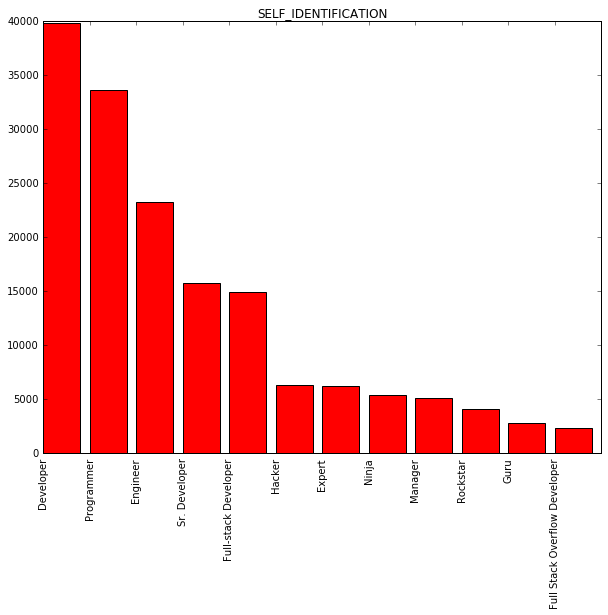

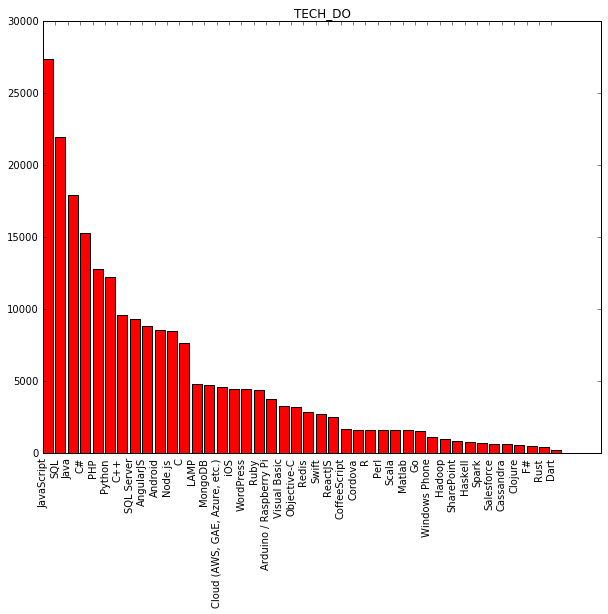

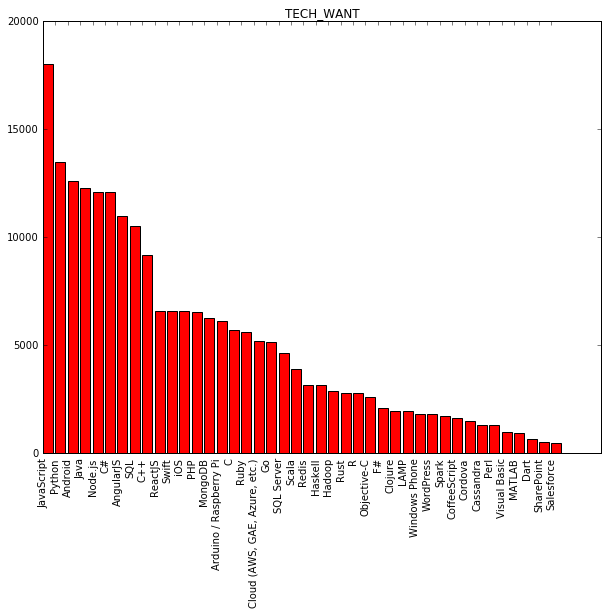

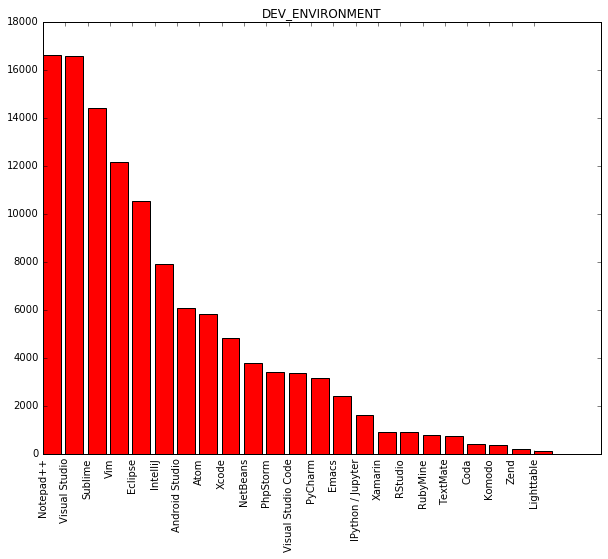

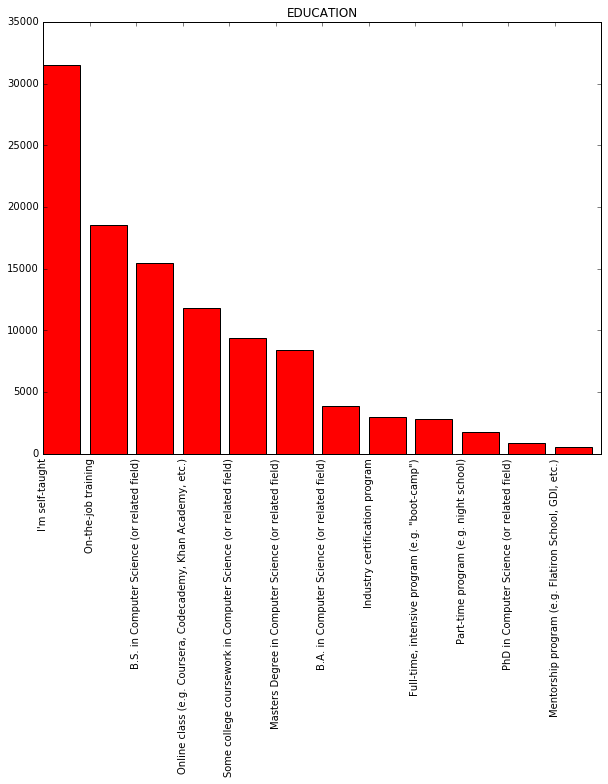

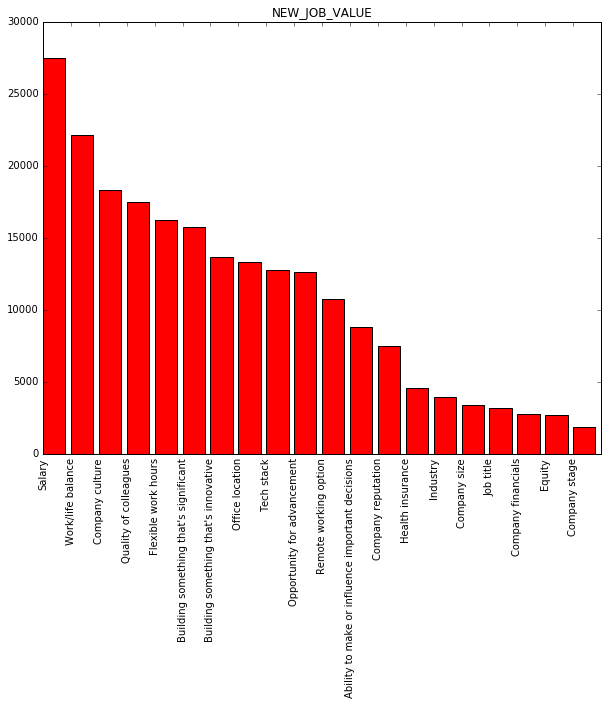

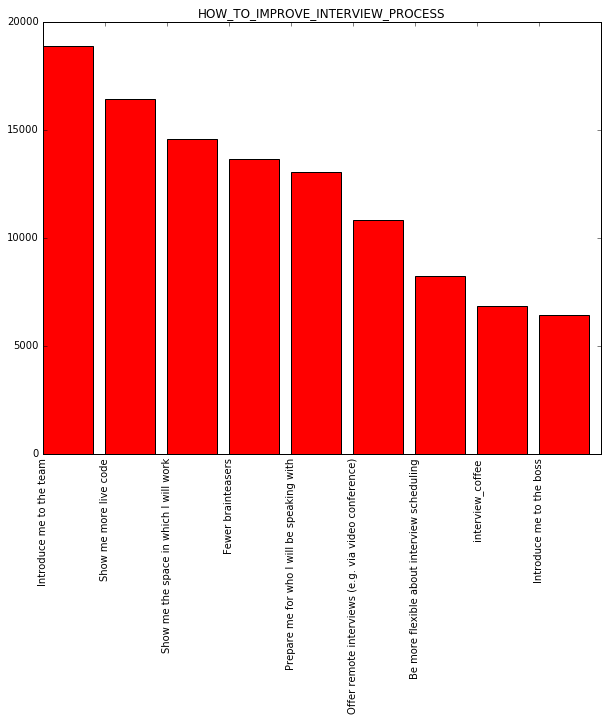

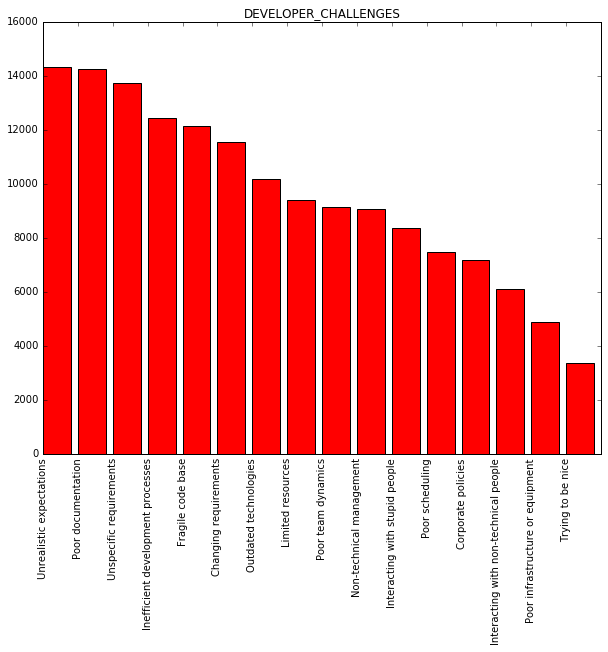

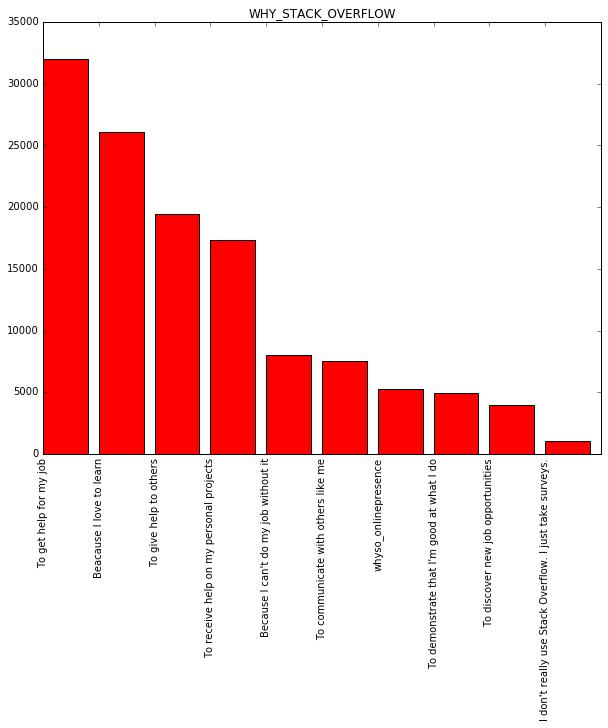

In [98]:
# plot bar graphs
for column in large_columns:
    plot_bernoulli_df((plot_axes(df,column)))

In [135]:
# Let's test an ML algorithm to predict the language a person is using, based on the dev environment
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import time

edu_df = convert_to_bernoulli_columns(df, 'education')
X, y = edu_df, df['star_wars_vs_star_trek']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


def support_vector_machines(X_train, y_train, X_test, y_test):
    a = time.time()
    clf = SVC().fit(X_train, y_train)
    b = time.time()
    clf.predict(y_train)
    
    
    
    
    
clf = SVC().fit(X_train, y_train)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

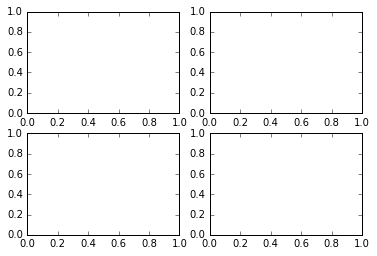

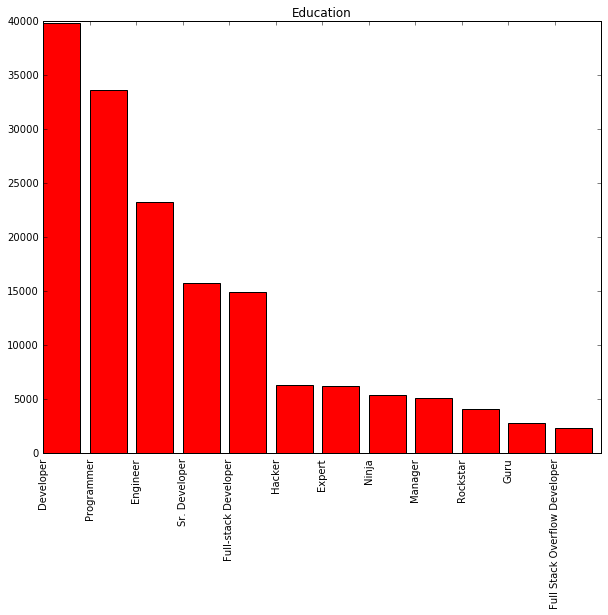

TypeError: 'NoneType' object is not iterable

In [11]:
# Create subplots here, so we can see all the columns data together

# adjusting subplots
gs = GridSpec(2,2,
              width_ratios=[1,1],
              height_ratios=[1,1])
ax1 = pl.subplot(gs[0])
ax2 = pl.subplot(gs[1])
ax3 = pl.subplot(gs[2])
ax4 = pl.subplot(gs[3])

axes = (ax1, ax2, ax3, ax4)
color = ('r', 'y', 'g', 'b')

def binary_counter(n):
    s = ""
    if n == 0: s = "00"
    while n > 0:
        s = str(1 & n) + s
        n /= 2
        
    if len(s) == 1:
        s = "0" + s
        
    return s
        

# filling in x and y data for each graph
for ax, column_name, c, n in zip(axes, large_columns[0:4], color, range(0, 4)):
    if len([int(x) for x in binary_counter(n).split()]) == 1:
        i = 0
    else:
        i, j = [int(x) for x in binary_counter(n).split()]
    x, y = plot_bernoulli_df((plot_axes(df, column_name)))
    x = range(0, len(x))
    ax.bar(x, y, color=c)
    ax[i, j].set_title('hello')
    ax.plot(x, y)

In [162]:
## target_col1 = df['open_to_new_job']
target_col2 = df['dev_environment']
target_col3 = df['employment_status']

all_answers_col1 = {}
for i in target_col1:
    if i not in all_answers_col1:
        all_answers_col1[i] = 1
    else:
        all_answers_col1[i] += 1
    
for answer, count in all_answers_col1.iteritems():
    print answer, count


nan 11650
I'm not actively looking, but I am open to new opportunities 27848
I am not interested in new job opportunities 9674
I am actively looking for a new job 6858


In [86]:
all_col2 = {}
for i, data in enumerate(target_col2):
    data = str(data).split('; ')
    
    for j in data:
        if j not in all_col2:
            all_col2[j] = 1
        else:
            all_col2[j] += 1
            
all_col2

{'Android Studio': 6073,
 'Atom': 5825,
 'Coda': 414,
 'Eclipse': 10564,
 'Emacs': 2433,
 'IPython / Jupyter': 1626,
 'IntelliJ': 7938,
 'Komodo': 379,
 'Lighttable': 143,
 'NetBeans': 3773,
 'Notepad++': 16607,
 'PhpStorm': 3437,
 'PyCharm': 3175,
 'RStudio': 917,
 'RubyMine': 805,
 'Sublime': 14434,
 'TextMate': 753,
 'Vim': 12180,
 'Visual Studio': 16580,
 'Visual Studio Code': 3371,
 'Xamarin': 934,
 'Xcode': 4822,
 'Zend': 224,
 'nan': 10317}